# Bayesian Vector Autoregression Tutorial
## Following Woźniak (2016) Methodology

This notebook implements Bayesian Vector Autoregressions (VAR) following the theoretical framework presented in Woźniak, T. (2016). "Bayesian vector autoregressions." *Australian Economic Review*, 49(3), 365-380.

---

## 1. Data Simulation

I begin by simulating VAR data to understand the data generating process and create a controlled environment for testing our Bayesian estimation methods.

### VAR Model Structure

The VAR(p) model is defined as:
$$y_t = \mu + A_1 y_{t-1} + A_2 y_{t-2} + \ldots + A_p y_{t-p} + u_t$$

where:
- $y_t$ is an $N \times 1$ vector of endogenous variables
- $\mu$ is an $N \times 1$ vector of constants  
- $A_i$ are $N \times N$ coefficient matrices
- $u_t \sim N(0, \Sigma)$ are error terms

### Simulation Parameters

The following cell generates synthetic VAR data with known parameters, allowing us to evaluate the performance of our Bayesian estimation against the true data generating process.

Simulating VAR Data for Bayesian Estimation
VAR MODEL INFORMATION
Dimensions: N=3 variables, p=2 lags, T=1002 observations

Constants (μ):
[ 0.04967142 -0.01382643  0.06476885]

AR Coefficients A1:
[[ 0.7        -0.06879627 -0.0688011 ]
 [-0.08838328  0.7         0.07323523]
 [ 0.020223    0.04161452  0.7       ]]

AR Coefficients A2:
[[-0.2876493   0.28194591  0.19946558]
 [-0.17259653 -0.19090502 -0.18995729]
 [-0.11745465  0.01485386 -0.04083299]]

Error Covariance (Σ):
[[ 1.         -0.02187515 -0.26411003]
 [-0.02187515  1.          0.11283227]
 [-0.26411003  0.11283227  1.        ]]

Data Summary:
Mean: [-0.03507968 -0.18900753  0.28615067]
Std:  [1.44061299 1.43957979 1.40279666]

Design Matrices:
Y_matrix shape: (1000, 3)
X_matrix shape: (1000, 7)
K (total regressors): 7


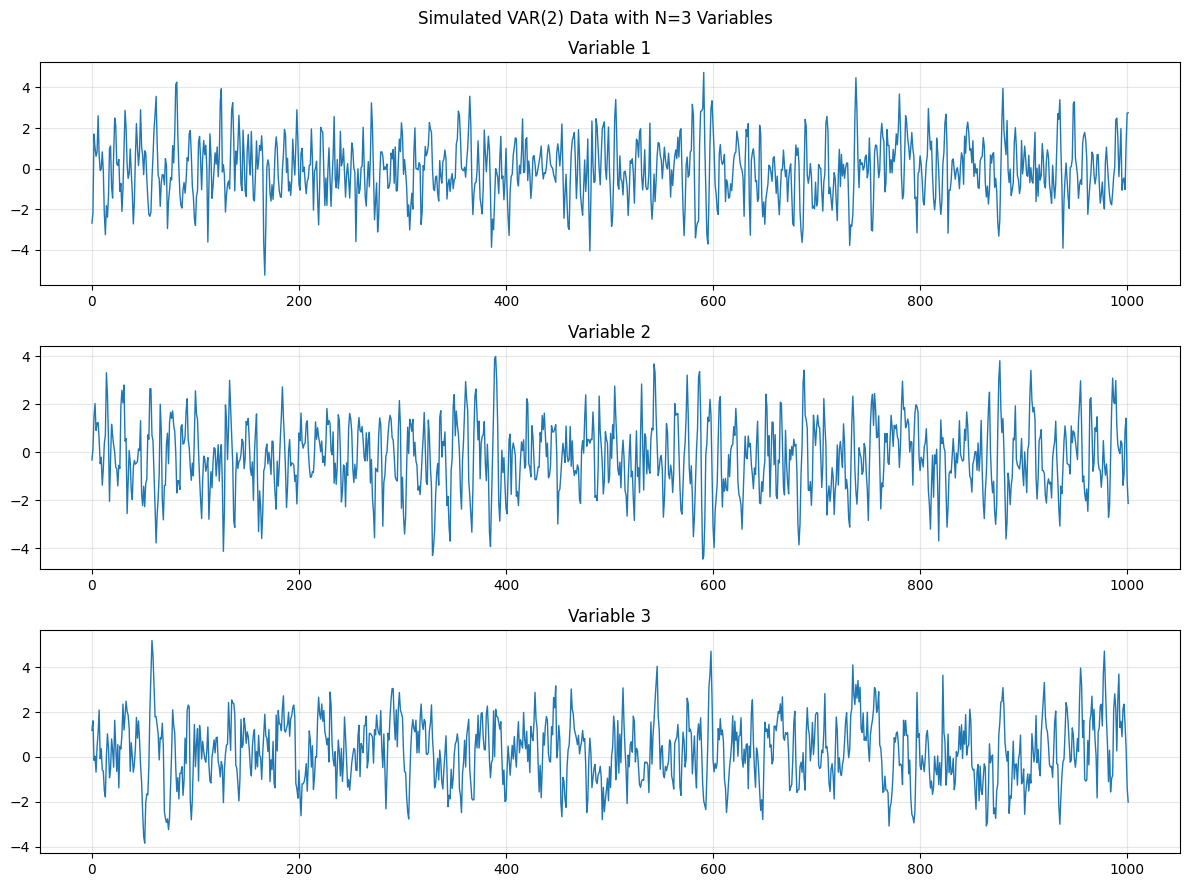


DataFrame created:
            y1        y2        y3
time                              
0    -2.677009 -0.316799  1.180473
1    -2.187928  0.123147  1.608976
2     1.707364  1.488523 -0.148518
3     1.027383  2.035054  0.030674
4     0.611106  0.915317 -0.674406

DataFrame info:
                y1           y2           y3
count  1002.000000  1002.000000  1002.000000
mean     -0.035080    -0.189008     0.286151
std       1.441332     1.440299     1.403497
min      -5.238606    -4.447078    -3.839269
25%      -0.967462    -1.141142    -0.637558
50%      -0.056998    -0.215329     0.299860
75%       0.838376     0.803808     1.239715
max       4.734963     3.995332     5.186342

Data simulation completed!
Variables available:
- Y: simulated data (T x N)
- Y_matrix: dependent vars for estimation
- X_matrix: regressors for estimation
- mu_true, A_true, Sigma_true: true parameters
- df: pandas DataFrame of the data


In [7]:
# Simulating data

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed
np.random.seed(42)

def generate_var_coefficients(N, p, persistence=0.7, cross_effects=0.1):
    """
    Generate VAR coefficients A1, A2, ..., Ap
    
    Parameters:
    N : jumlah variabel
    p : jumlah lag
    persistence : diagonal elements A1 (autoregressive effect)
    cross_effects : off-diagonal elements
    """
    A = np.zeros((N, N, p))
    
    # A1: persistence di diagonal, cross-effects di off-diagonal
    A[:, :, 0] = persistence * np.eye(N)
    np.fill_diagonal(A[:, :, 0], persistence)
    
    # Add cross effects
    for i in range(N):
        for j in range(N):
            if i != j:
                A[i, j, 0] = np.random.uniform(-cross_effects, cross_effects)
    
    # A2, A3, ..., Ap dengan efek yang menurun
    for lag in range(1, p):
        decay = 0.3 / lag  # Efek menurun
        A[:, :, lag] = np.random.uniform(-decay, decay, (N, N))
    
    return A

def generate_covariance_matrix(N, correlation=0.3):
    """Generate positive definite covariance matrix"""
    if N == 1:
        return np.array([[1.0]])
    
    # Generate random correlation
    R = np.random.randn(N, N)
    R = R @ R.T
    
    # Normalize to correlation matrix
    d = np.sqrt(np.diag(R))
    R = R / np.outer(d, d)
    
    # Apply correlation strength
    Sigma = (1 - correlation) * np.eye(N) + correlation * R
    
    return Sigma

def simulate_var_data(N, p, T, mu=None, A=None, Sigma=None, burn_in=100):
    """
    Simulate VAR(p) data
    
    Parameters:
    N : jumlah variabel
    p : jumlah lag  
    T : sample size
    mu : konstanta (N x 1)
    A : AR coefficients (N x N x p)
    Sigma : error covariance (N x N)
    burn_in : observasi awal yang dibuang
    """
    # Set default parameters
    if mu is None:
        mu = np.random.normal(0, 0.1, N)
    
    if A is None:
        A = generate_var_coefficients(N, p)
    
    if Sigma is None:
        Sigma = generate_covariance_matrix(N)
    
    # Total sample dengan burn-in
    total_T = T + burn_in + p
    Y = np.zeros((total_T, N))
    
    # Initial conditions
    for t in range(p):
        Y[t, :] = np.random.multivariate_normal(mu, Sigma)
    
    # Generate VAR process
    for t in range(p, total_T):
        # AR component
        ar_part = np.zeros(N)
        for lag in range(p):
            ar_part += A[:, :, lag] @ Y[t-1-lag, :]
        
        # Mean + AR + Error
        mean_t = mu + ar_part
        error_t = np.random.multivariate_normal(np.zeros(N), Sigma)
        Y[t, :] = mean_t + error_t
    
    # Remove burn-in
    Y_final = Y[burn_in:, :]
    
    return Y_final, mu, A, Sigma

def create_design_matrices(Y, p):
    """
    Create design matrices for VAR estimation
    
    Returns:
    Y_matrix : (T-p) x N dependent variables
    X_matrix : (T-p) x K regressors [1, y_{t-1}, ..., y_{t-p}]
    """
    T, N = Y.shape
    T_effective = T - p
    K = 1 + p * N  # konstanta + p lags * N variables
    
    # Y matrix (dependent variables)
    Y_matrix = Y[p:, :]
    
    # X matrix (regressors)
    X_matrix = np.zeros((T_effective, K))
    
    for t in range(T_effective):
        col_idx = 0
        
        # Konstanta
        X_matrix[t, col_idx] = 1
        col_idx += 1
        
        # Lagged variables
        for lag in range(p):
            Y_lag = Y[p + t - 1 - lag, :]  # y_{t-1-lag}
            X_matrix[t, col_idx:col_idx+N] = Y_lag
            col_idx += N
    
    return Y_matrix, X_matrix

def plot_var_data(Y, title="Simulated VAR Data"):
    """Plot time series data"""
    T, N = Y.shape
    
    fig, axes = plt.subplots(N, 1, figsize=(12, 3*N))
    if N == 1:
        axes = [axes]
    
    for i in range(N):
        axes[i].plot(Y[:, i], linewidth=1)
        axes[i].set_title(f'Variable {i+1}')
        axes[i].grid(True, alpha=0.3)
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

def print_var_info(Y, mu, A, Sigma):
    """Print VAR model information"""
    T, N = Y.shape
    p = A.shape[2]
    
    print("="*50)
    print("VAR MODEL INFORMATION")
    print("="*50)
    print(f"Dimensions: N={N} variables, p={p} lags, T={T} observations")
    print(f"\nConstants (μ):")
    print(mu)
    print(f"\nAR Coefficients A1:")
    print(A[:, :, 0])
    if p > 1:
        print(f"\nAR Coefficients A2:")
        print(A[:, :, 1])
    print(f"\nError Covariance (Σ):")
    print(Sigma)
    print(f"\nData Summary:")
    print(f"Mean: {np.mean(Y, axis=0)}")
    print(f"Std:  {np.std(Y, axis=0)}")

# =============================================================================
# IMPLEMENTASI
# =============================================================================

print("Simulating VAR Data for Bayesian Estimation")
print("=" * 50)

# Parameter simulasi
N = 3      # 3 variabel
p = 2      # VAR(2)  
T = 1000    # 200 observasi

# Simulate data
Y, mu_true, A_true, Sigma_true = simulate_var_data(N, p, T)

# Print info
print_var_info(Y, mu_true, A_true, Sigma_true)

# Create design matrices untuk estimasi
Y_matrix, X_matrix = create_design_matrices(Y, p)

print(f"\nDesign Matrices:")
print(f"Y_matrix shape: {Y_matrix.shape}")  
print(f"X_matrix shape: {X_matrix.shape}")
print(f"K (total regressors): {X_matrix.shape[1]}")

# Plot data
plot_var_data(Y, "Simulated VAR(2) Data with N=3 Variables")

# Create DataFrame untuk analisis lebih lanjut
df = pd.DataFrame(Y, columns=[f'y{i+1}' for i in range(N)])
df.index.name = 'time'

print(f"\nDataFrame created:")
print(df.head())
print(f"\nDataFrame info:")
print(df.describe())

print("\n" + "="*50)
print("Data simulation completed!")
print("Variables available:")
print("- Y: simulated data (T x N)")  
print("- Y_matrix: dependent vars for estimation")
print("- X_matrix: regressors for estimation")
print("- mu_true, A_true, Sigma_true: true parameters")
print("- df: pandas DataFrame of the data")
print("="*50)

---

## 2. Likelihood Function

This section implements the likelihood function for the VAR model, which forms the foundation for Bayesian inference. Following Woźniak (2016), I express the likelihood in matrix-variate normal form.

### Theoretical Background

The likelihood function for the VAR model can be written as:
$$L(A, \Sigma; Y) = (2\pi)^{-\frac{TN}{2}} |\Sigma|^{-\frac{T}{2}} \exp\left(-\frac{1}{2} \text{tr}[\Sigma^{-1}(Y-XA)'(Y-XA)]\right)$$

### Normal-Wishart Decomposition

A key insight from Woźniak (2016) is that the likelihood can be decomposed into Normal-Wishart form:

- **Conditional distribution of A**: $A|Y,\Sigma \sim MN_{K \times N}(\hat{A}, \Sigma, (X'X)^{-1})$
- **Marginal distribution of Σ**: $\Sigma|Y \sim IW_N(\hat{S}, T-K-N-1)$

where $\hat{A} = (X'X)^{-1}X'Y$ is the OLS estimator and $\hat{S}$ is the residual sum of squares matrix.

### Design Matrices

The code creates the design matrices:
- **Y_matrix**: $(T-p) \times N$ matrix of dependent variables
- **X_matrix**: $(T-p) \times K$ matrix of regressors $[1, y_{t-1}, y_{t-2}, \ldots, y_{t-p}]$

This likelihood representation will be combined with prior distributions to derive the posterior in the next section.

In [8]:
# Likelihood function

from scipy import linalg
from scipy.stats import multivariate_normal, invwishart

def ols_estimator(Y_matrix, X_matrix):
    """
    OLS estimator untuk VAR
    A_hat = (X'X)^-1 X'Y
    """
    XtX_inv = linalg.inv(X_matrix.T @ X_matrix)
    A_hat = XtX_inv @ X_matrix.T @ Y_matrix
    
    return A_hat, XtX_inv

def compute_residuals(Y_matrix, X_matrix, A_hat):
    """
    Compute residuals: U = Y - XA
    """
    U = Y_matrix - X_matrix @ A_hat
    return U

def likelihood_normal_wishart_form(Y_matrix, X_matrix):
    """
    Likelihood function dalam bentuk Normal-Wishart (Persamaan 16)
    
    Returns:
    A_hat : OLS estimator koefisien
    XtX_inv : (X'X)^-1 untuk covariance A
    S_hat : residual sum of squares matrix
    df : degrees of freedom
    """
    T, N = Y_matrix.shape
    T_eff, K = X_matrix.shape
    
    # OLS estimator
    A_hat, XtX_inv = ols_estimator(Y_matrix, X_matrix)
    
    # Residuals
    U = compute_residuals(Y_matrix, X_matrix, A_hat)
    
    # Residual sum of squares matrix
    S_hat = U.T @ U
    
    # Degrees of freedom
    df = T - K - N - 1
    
    print("Likelihood Function - Normal-Wishart Form")
    print("="*45)
    print(f"A|Y,Σ ~ MN_{K}×{N}(A_hat, Σ, (X'X)^-1)")
    print(f"Σ|Y ~ IW_{N}(S_hat, {df})")
    print(f"\nA_hat shape: {A_hat.shape}")
    print(f"(X'X)^-1 shape: {XtX_inv.shape}")
    print(f"S_hat shape: {S_hat.shape}")
    print(f"Degrees of freedom: {df}")
    
    return A_hat, XtX_inv, S_hat, df

def log_likelihood_value(Y_matrix, X_matrix, A, Sigma):
    """
    Compute log-likelihood value untuk parameter A dan Sigma tertentu
    Berdasarkan persamaan (14)
    
    L(A,Σ;Y) ∝ |Σ|^(-T/2) * exp(-1/2 * tr[Σ^-1(Y-XA)'(Y-XA)])
    """
    T, N = Y_matrix.shape
    
    # Residuals
    U = Y_matrix - X_matrix @ A
    
    # Log-determinant term
    sign, logdet_Sigma = np.linalg.slogdet(Sigma)
    log_det_term = -0.5 * T * logdet_Sigma
    
    # Quadratic form
    Sigma_inv = linalg.inv(Sigma)
    quad_form = np.trace(Sigma_inv @ U.T @ U)
    quad_term = -0.5 * quad_form
    
    # Constant term (dapat diabaikan untuk optimization)
    const_term = -0.5 * T * N * np.log(2 * np.pi)
    
    log_likelihood = const_term + log_det_term + quad_term
    
    return log_likelihood

def likelihood_at_ols(Y_matrix, X_matrix):
    """
    Evaluate likelihood pada OLS estimates
    """
    T, N = Y_matrix.shape
    
    # OLS estimates
    A_hat, _ = ols_estimator(Y_matrix, X_matrix)
    U = compute_residuals(Y_matrix, X_matrix, A_hat)
    Sigma_hat = (U.T @ U) / T  # ML estimator
    
    # Log-likelihood
    ll = log_likelihood_value(Y_matrix, X_matrix, A_hat, Sigma_hat)
    
    print(f"Likelihood evaluated at OLS estimates:")
    print(f"Log-likelihood: {ll:.2f}")
    
    return ll, A_hat, Sigma_hat

def matric_variate_normal_pdf(A, M, Sigma, V_inv):
    """
    Matric-variate normal PDF untuk A|Y,Σ
    Persamaan: MN(M, Σ, V)
    """
    K, N = A.shape
    
    # Log-determinant terms
    sign_Sigma, logdet_Sigma = np.linalg.slogdet(Sigma)
    sign_V, logdet_V = np.linalg.slogdet(linalg.inv(V_inv))
    
    log_det_term = -0.5 * K * logdet_Sigma - 0.5 * N * logdet_V
    
    # Quadratic form
    diff = A - M
    Sigma_inv = linalg.inv(Sigma)
    quad_form = np.trace(Sigma_inv @ diff.T @ V_inv @ diff)
    quad_term = -0.5 * quad_form
    
    # Constant
    const_term = -0.5 * K * N * np.log(2 * np.pi)
    
    log_pdf = const_term + log_det_term + quad_term
    
    return log_pdf

def inverse_wishart_pdf(Sigma, S, df):
    """
    Inverse Wishart PDF untuk Σ|Y
    """
    N = Sigma.shape[0]
    
    # Log-determinant terms
    sign_Sigma, logdet_Sigma = np.linalg.slogdet(Sigma)
    sign_S, logdet_S = np.linalg.slogdet(S)
    
    log_det_term = -0.5 * (df + N + 1) * logdet_Sigma + 0.5 * df * logdet_S
    
    # Trace term
    Sigma_inv = linalg.inv(Sigma)
    trace_term = -0.5 * np.trace(Sigma_inv @ S)
    
    # Normalization constant (dapat diabaikan)
    log_pdf = log_det_term + trace_term
    
    return log_pdf

def reshape_true_parameters(mu_true, A_true, N, p):
    """
    Reshape true parameters dari simulasi ke format yang sesuai X_matrix
    
    Parameters:
    mu_true : (N,) konstanta
    A_true : (N, N, p) AR coefficients  
    N : jumlah variabel
    p : jumlah lag
    
    Returns:
    A_true_full : (K, N) dimana K = 1 + p*N
                  Format: [μ, A₁, A₂, ..., Aₚ] stacked by rows
    """
    K = 1 + p * N
    A_true_full = np.zeros((K, N))
    
    # Row 0: konstanta μ
    A_true_full[0, :] = mu_true
    
    # Rows untuk setiap lag
    for lag in range(p):
        start_row = 1 + lag * N
        end_row = 1 + (lag + 1) * N
        A_true_full[start_row:end_row, :] = A_true[:, :, lag]
    
    return A_true_full

# =============================================================================
# IMPLEMENTASI MENGGUNAKAN DATA SIMULASI
# =============================================================================

# Menggunakan data dari simulasi sebelumnya
# Pastikan Y_matrix dan X_matrix sudah ada dari code sebelumnya

print("VAR Likelihood Function Analysis")
print("="*50)

# 1. Likelihood dalam bentuk Normal-Wishart
A_hat, XtX_inv, S_hat, df = likelihood_normal_wishart_form(Y_matrix, X_matrix)

print(f"\nOLS Estimator A_hat:")
print(A_hat)

print(f"\nResidual Sum of Squares S_hat:")
print(S_hat)

# 2. Expected value dari Sigma dalam likelihood
Sigma_expected = S_hat / df
print(f"\nExpected Σ|Y (from likelihood):")
print(Sigma_expected)

print(f"\nTrue Sigma (from simulation):")
print(Sigma_true)

print(f"\nDifference:")
print(Sigma_expected - Sigma_true)

# 3. Likelihood value pada OLS estimates
ll_ols, A_ols, Sigma_ols = likelihood_at_ols(Y_matrix, X_matrix)

# 4. Reshape true parameters dan likelihood value pada true parameters
A_true_full = reshape_true_parameters(mu_true, A_true, N, p)
ll_true = log_likelihood_value(Y_matrix, X_matrix, A_true_full, Sigma_true)

print(f"\nParameter Comparison:")
print(f"A_true_full shape: {A_true_full.shape}")
print(f"A_hat shape: {A_hat.shape}")

print(f"\nLikelihood Comparison:")
print(f"Log-likelihood at OLS:  {ll_ols:.2f}")
print(f"Log-likelihood at TRUE: {ll_true:.2f}")
print(f"Difference:            {ll_ols - ll_true:.2f}")

# 5. Matric-variate normal PDF untuk A
log_mvn = matric_variate_normal_pdf(A_hat, A_hat, Sigma_expected, 
                                   linalg.inv(XtX_inv))
print(f"\nMatric-variate Normal log-PDF (A at mode): {log_mvn:.2f}")

# 6. Inverse Wishart PDF untuk Sigma  
log_iw = inverse_wishart_pdf(Sigma_expected, S_hat, df)
print(f"Inverse Wishart log-PDF (Σ at mode): {log_iw:.2f}")

print("\n" + "="*50)
print("Likelihood Function Analysis Completed!")
print("Key Results:")
print(f"- OLS performs {'better' if ll_ols > ll_true else 'worse'} than true parameters")
print(f"- Likelihood decomposed into Normal-Wishart form")
print(f"- Ready for Bayesian inference!")
print("="*50)

VAR Likelihood Function Analysis
Likelihood Function - Normal-Wishart Form
A|Y,Σ ~ MN_7×3(A_hat, Σ, (X'X)^-1)
Σ|Y ~ IW_3(S_hat, 989)

A_hat shape: (7, 3)
(X'X)^-1 shape: (7, 7)
S_hat shape: (3, 3)
Degrees of freedom: 989

OLS Estimator A_hat:
[[-0.03049977 -0.07588028  0.12318629]
 [ 0.66413436 -0.07778055  0.03773423]
 [-0.0514263   0.70684674  0.0548487 ]
 [-0.08243211  0.09670621  0.66948328]
 [-0.27309456 -0.18066936 -0.1534055 ]
 [ 0.2423618  -0.21801374  0.06382139]
 [ 0.24712617 -0.20552044 -0.05012122]]

Residual Sum of Squares S_hat:
[[1015.91441865  -35.74411916 -292.59136159]
 [ -35.74411916  948.87682153  161.59981624]
 [-292.59136159  161.59981624  982.43687561]]

Expected Σ|Y (from likelihood):
[[ 1.02721377 -0.03614168 -0.29584566]
 [-0.03614168  0.95943056  0.16339719]
 [-0.29584566  0.16339719  0.99336388]]

True Sigma (from simulation):
[[ 1.         -0.02187515 -0.26411003]
 [-0.02187515  1.          0.11283227]
 [-0.26411003  0.11283227  1.        ]]

Difference:
[[

---

## 3. Minnesota Prior

This section implements the Minnesota prior, a key innovation in Bayesian VAR modeling that incorporates reasonable beliefs about macroeconomic time series behavior without seeing the data.

### Economic Motivation

The Minnesota prior reflects the empirical observation that many macroeconomic variables follow unit-root processes. The prior expresses the belief that:
- Current values of variables are well approximated by their lagged values (random walk)
- Effects of distant lags decay rapidly
- Cross-variable effects are smaller than own-variable effects

### Prior Structure

Following Woźniak (2016), the Minnesota prior has the form:
$$A|\Sigma \sim MN_{K \times N}(\bar{A}, \Sigma, \underline{V})$$
$$\Sigma \sim IW_N(\underline{S}, \underline{\nu})$$

### Prior Mean: Random Walk Assumption

The prior mean $\bar{A}$ embodies the random walk belief:
$$\bar{A} = [0, I_N, 0_{N \times N}, \ldots, 0_{N \times N}]'$$

This sets:
- Constants ($\mu$) = 0
- First lag coefficients ($A_1$) = Identity matrix
- Higher lag coefficients ($A_2, A_3, \ldots$) = 0

### Prior Covariance: Shrinkage Structure

The diagonal matrix $\underline{V}$ controls shrinkage intensity:
$$V_{ii} = \begin{cases}
\lambda_0 & \text{for constants} \\
\frac{\lambda_1}{l^2 \hat{\sigma}_n^2} & \text{for lag } l \text{ of variable } n
\end{cases}$$

**Hyperparameters:**
- $\lambda_0$: Controls shrinkage of constant terms
- $\lambda_1$: Controls shrinkage of autoregressive coefficients
- $\hat{\sigma}_n^2$: Univariate AR error variance for variable $n$

The $1/l^2$ factor ensures distant lags are shrunk more aggressively toward zero.

Setting up Minnesota Prior Distribution
Minnesota Prior Setup:
λ₀ (konstanta shrinkage): 1.0
λ₁ (AR shrinkage): 0.2
ν (degrees of freedom): 5
Univariate AR variances: [1.38092579 1.21833828 1.0613324 ]
A_bar shape: (7, 3)
V shape: (7, 7)
S shape: (3, 3)

Prior Mean A_bar:
[[0. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]

Prior Covariance V (diagonal elements):
[1.         0.14483037 0.16415802 0.18844238 0.03620759 0.0410395
 0.04711059]

Prior Scale Matrix S:
[[1.38092579 0.         0.        ]
 [0.         1.21833828 0.        ]
 [0.         0.         1.0613324 ]]

Prior PDF Evaluation:
Log-prior at TRUE params: -6.22
Log-prior at OLS params:  -6.96
Difference:              -0.73

Random Walk Prior vs True Parameters:
Prior mean A_bar[1:4,:] (A1):
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
True A1:
[[ 0.7        -0.06879627 -0.0688011 ]
 [-0.08838328  0.7         0.07323523]
 [ 0.020223    0.04161452  0.7       ]]
Difference:
[[ 0.3         0.06879627  

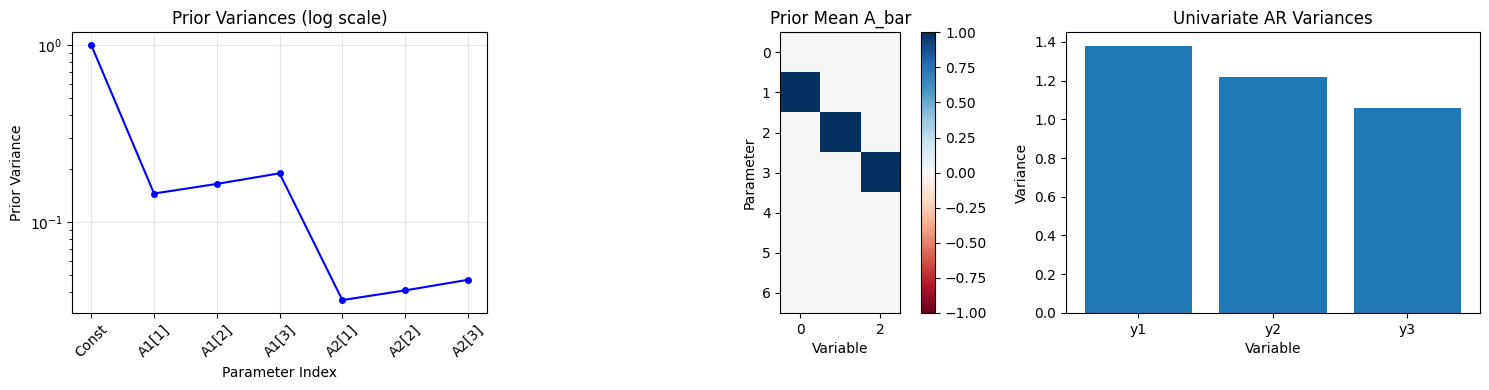


Minnesota Prior Setup Completed!
Key Components:
- A_bar: Random walk prior mean
- V: Shrinkage covariance matrix
- S_prior: Scale matrix for Σ
- nu: Degrees of freedom
Ready for Bayesian inference!


In [10]:
# Minnesota Prior

import matplotlib.pyplot as plt

def estimate_univariate_ar_variances(Y, p=1):
    """
    Estimate univariate AR error variances untuk Minnesota prior
    
    Parameters:
    Y : (T, N) data matrix
    p : lag order untuk univariate AR
    
    Returns:
    sigma_hat_squared : (N,) array of error variances
    """
    T, N = Y.shape
    sigma_hat_squared = np.zeros(N)
    
    for i in range(N):
        y = Y[:, i]
        
        # Create lagged data untuk univariate AR(p)
        y_dep = y[p:]
        X_ar = np.column_stack([np.ones(len(y_dep))] + 
                              [y[p-j:-j] for j in range(1, p+1)])
        
        # OLS regression
        beta = linalg.inv(X_ar.T @ X_ar) @ X_ar.T @ y_dep
        residuals = y_dep - X_ar @ beta
        
        # Error variance
        sigma_hat_squared[i] = np.var(residuals, ddof=p+1)
    
    return sigma_hat_squared

def create_minnesota_prior_V(N, p, lambda_0, lambda_1, sigma_hat_squared):
    """
    Create Minnesota prior covariance matrix V
    
    Parameters:
    N : jumlah variabel
    p : lag order
    lambda_0 : shrinkage parameter untuk konstanta
    lambda_1 : shrinkage parameter untuk AR coefficients  
    sigma_hat_squared : (N,) univariate AR error variances
    
    Returns:
    V : (K, K) prior covariance matrix (diagonal)
    """
    K = 1 + p * N
    V = np.zeros((K, K))
    
    # Konstanta (first element)
    V[0, 0] = lambda_0
    
    # AR coefficients
    idx = 1
    for lag in range(1, p + 1):  # lag = 1, 2, ..., p
        for var in range(N):     # variable = 1, 2, ..., N
            V[idx, idx] = lambda_1 / (lag**2 * sigma_hat_squared[var])
            idx += 1
    
    return V

def create_minnesota_prior_mean(N, p):
    """
    Create Minnesota prior mean A_bar (random walk assumption)
    
    Returns:
    A_bar : (K, N) prior mean matrix
    """
    K = 1 + p * N
    A_bar = np.zeros((K, N))
    
    # Random walk: y_t = y_{t-1} + u_t
    # Konstanta = 0, A1 = I_N, A2 = ... = Ap = 0
    
    # A1 diagonal = 1 (unit root assumption)
    for i in range(N):
        A_bar[1 + i, i] = 1.0  # A1[i,i] = 1
    
    # A2, A3, ..., Ap = 0 (already zero-initialized)
    
    return A_bar

def minnesota_prior_parameters(Y, p, lambda_0=1.0, lambda_1=0.2, nu=None, S_scale=1.0):
    """
    Set up complete Minnesota prior parameters
    
    Parameters:
    Y : (T, N) data
    p : lag order
    lambda_0 : shrinkage untuk konstanta
    lambda_1 : shrinkage untuk AR coefficients
    nu : degrees of freedom untuk Inverse Wishart (default: N+2)
    S_scale : scaling factor untuk S matrix
    
    Returns:
    A_bar : prior mean
    V : prior covariance  
    S : scale matrix untuk Sigma
    nu : degrees of freedom
    """
    T, N = Y.shape
    
    # 1. Univariate AR variances
    sigma_hat_squared = estimate_univariate_ar_variances(Y, p=1)
    
    # 2. Prior mean (random walk)
    A_bar = create_minnesota_prior_mean(N, p)
    
    # 3. Prior covariance matrix V
    V = create_minnesota_prior_V(N, p, lambda_0, lambda_1, sigma_hat_squared)
    
    # 4. Prior for Sigma (Inverse Wishart)
    if nu is None:
        nu = N + 2  # Slightly informative
    
    # S matrix: diagonal dengan univariate variances
    S = S_scale * np.diag(sigma_hat_squared)
    
    print("Minnesota Prior Setup:")
    print("=" * 40)
    print(f"λ₀ (konstanta shrinkage): {lambda_0}")
    print(f"λ₁ (AR shrinkage): {lambda_1}")
    print(f"ν (degrees of freedom): {nu}")
    print(f"Univariate AR variances: {sigma_hat_squared}")
    print(f"A_bar shape: {A_bar.shape}")
    print(f"V shape: {V.shape}")
    print(f"S shape: {S.shape}")
    
    return A_bar, V, S, nu, sigma_hat_squared

def evaluate_minnesota_prior_pdf(A, Sigma, A_bar, V, S, nu):
    """
    Evaluate Minnesota prior PDF sesuai persamaan (19)
    
    p(A,Σ) ∝ |Σ|^(-(ν+N+K+1)/2) * exp(-1/2 * tr[Σ^(-1)(A-A_bar)'V^(-1)(A-A_bar)])
                                  * exp(-1/2 * tr[Σ^(-1)S])
    """
    K, N = A.shape
    
    # Log determinant Sigma
    sign, logdet_Sigma = np.linalg.slogdet(Sigma)
    log_det_term = -0.5 * (nu + N + K + 1) * logdet_Sigma
    
    # Quadratic form untuk A
    A_diff = A - A_bar
    V_inv = linalg.inv(V)
    Sigma_inv = linalg.inv(Sigma)
    
    quad_A = np.trace(Sigma_inv @ A_diff.T @ V_inv @ A_diff)
    quad_A_term = -0.5 * quad_A
    
    # Trace term untuk S
    trace_S = np.trace(Sigma_inv @ S)
    trace_S_term = -0.5 * trace_S
    
    log_prior = log_det_term + quad_A_term + trace_S_term
    
    return log_prior

def plot_minnesota_prior_structure(V, A_bar, sigma_hat_squared, N, p):
    """Plot struktur Minnesota prior"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # 1. Prior covariance matrix V (diagonal)
    axes[0].semilogy(np.diag(V), 'bo-', markersize=4)
    axes[0].set_title('Prior Variances (log scale)')
    axes[0].set_xlabel('Parameter Index')
    axes[0].set_ylabel('Prior Variance')
    axes[0].grid(True, alpha=0.3)
    
    # Add labels
    labels = ['Const'] + [f'A{l}[{i}]' for l in range(1,p+1) for i in range(1,N+1)]
    axes[0].set_xticks(range(len(labels)))
    axes[0].set_xticklabels(labels, rotation=45)
    
    # 2. Prior mean A_bar
    vmax = np.max(np.abs(A_bar))
    im = axes[1].imshow(A_bar, cmap='RdBu', vmin=-vmax, vmax=vmax)
    axes[1].set_title('Prior Mean A_bar')
    axes[1].set_xlabel('Variable')
    axes[1].set_ylabel('Parameter')
    plt.colorbar(im, ax=axes[1])
    
    # 3. Univariate AR variances
    axes[2].bar(range(N), sigma_hat_squared)
    axes[2].set_title('Univariate AR Variances')
    axes[2].set_xlabel('Variable')
    axes[2].set_ylabel('Variance')
    axes[2].set_xticks(range(N))
    axes[2].set_xticklabels([f'y{i+1}' for i in range(N)])
    
    plt.tight_layout()
    plt.show()

# =============================================================================
# IMPLEMENTASI MINNESOTA PRIOR
# =============================================================================

print("Setting up Minnesota Prior Distribution")
print("=" * 50)

# Hyperparameters
lambda_0 = 1.0    # Shrinkage untuk konstanta
lambda_1 = 0.2    # Shrinkage untuk AR coefficients
nu_prior = N + 2  # Degrees of freedom

# Setup Minnesota prior
A_bar, V, S_prior, nu, sigma_hat_sq = minnesota_prior_parameters(
    Y, p, lambda_0, lambda_1, nu_prior
)

print(f"\nPrior Mean A_bar:")
print(A_bar)

print(f"\nPrior Covariance V (diagonal elements):")
print(np.diag(V))

print(f"\nPrior Scale Matrix S:")
print(S_prior)

# Evaluate prior PDF pada true parameters
A_true_full = reshape_true_parameters(mu_true, A_true, N, p)
log_prior_true = evaluate_minnesota_prior_pdf(
    A_true_full, Sigma_true, A_bar, V, S_prior, nu
)

# Evaluate prior PDF pada OLS estimates  
log_prior_ols = evaluate_minnesota_prior_pdf(
    A_hat, Sigma_expected, A_bar, V, S_prior, nu
)

print(f"\nPrior PDF Evaluation:")
print(f"Log-prior at TRUE params: {log_prior_true:.2f}")
print(f"Log-prior at OLS params:  {log_prior_ols:.2f}")
print(f"Difference:              {log_prior_ols - log_prior_true:.2f}")

# Compare dengan random walk assumption
print(f"\nRandom Walk Prior vs True Parameters:")
print(f"Prior mean A_bar[1:4,:] (A1):")
print(A_bar[1:4, :])
print(f"True A1:")
print(A_true[:, :, 0])
print(f"Difference:")
print(A_bar[1:4, :] - A_true[:, :, 0])

# Plot prior structure
plot_minnesota_prior_structure(V, A_bar, sigma_hat_sq, N, p)

print("\n" + "=" * 50)
print("Minnesota Prior Setup Completed!")
print("Key Components:")
print("- A_bar: Random walk prior mean")
print("- V: Shrinkage covariance matrix")  
print("- S_prior: Scale matrix for Σ")
print("- nu: Degrees of freedom")
print("Ready for Bayesian inference!")
print("=" * 50)

---

## 4. Posterior Distribution

This section derives and computes the Bayesian posterior distribution by combining the likelihood function with the Minnesota prior. Thanks to the natural-conjugate property, I obtain analytical solutions.

### Bayes' Theorem

The posterior distribution follows from Bayes' rule:
$$p(A, \Sigma | Y) \propto p(Y | A, \Sigma) \times p(A, \Sigma)$$

### Natural Conjugacy Advantage

Since both the likelihood and prior are in Normal-Wishart form, the posterior maintains the same distributional family:
$$A|Y,\Sigma \sim MN_{K \times N}(A^*, \Sigma, V^*)$$
$$\Sigma|Y \sim IW_N(S^*, \nu^*)$$

### Analytical Posterior Parameters

Following Woźniak (2016) equation (25), the posterior parameters have closed-form solutions:

$$V^* = (\underline{V}^{-1} + X'X)^{-1}$$
$$A^* = V^*(\underline{V}^{-1}\bar{A} + X'Y)$$
$$\nu^* = \underline{\nu} + T$$
$$S^* = \underline{S} + Y'Y + \bar{A}'\underline{V}^{-1}\bar{A} - A^{*'}V^{*-1}A^*$$

### Bayesian Learning

The posterior represents optimal combination of:
- **Prior beliefs** (Minnesota assumptions)
- **Sample information** (likelihood from data)

The relative influence depends on:
- Sample size ($T$): Larger samples give more weight to likelihood
- Prior precision ($\underline{V}^{-1}$): Tighter priors maintain more influence

### Performance Evaluation

The code compares four estimates:
1. **True parameters** (from simulation)
2. **Prior mean** (Minnesota assumptions)
3. **OLS estimates** (maximum likelihood)
4. **Posterior mean** (Bayesian combination)

This demonstrates how Bayesian methods can improve upon pure frequentist approaches by incorporating reasonable prior information.

Computing Bayesian VAR Posterior Distribution
Posterior Parameters Computed:
V* shape: (7, 7)
A* shape: (7, 3)
S* shape: (3, 3)
ν*: 1005

Posterior Means:
E[A|Y]:
[[-0.03033442 -0.07515518  0.12273117]
 [ 0.66473832 -0.08147455  0.03590885]
 [-0.04709754  0.70734427  0.0561544 ]
 [-0.07832403  0.09208646  0.67028269]
 [-0.26891287 -0.17578495 -0.15001926]
 [ 0.23712757 -0.21460263  0.06249996]
 [ 0.24268061 -0.20043791 -0.04952119]]
E[Σ|Y]:
[[ 1.02180263 -0.03645796 -0.29101988]
 [-0.03645796  0.95265343  0.16177255]
 [-0.29101988  0.16177255  0.98392132]]

Posterior Standard Errors:
[[0.03351089 0.03235712 0.03288385]
 [0.02868726 0.02769957 0.02815047]
 [0.03106432 0.02999479 0.03048306]
 [0.03253051 0.0314105  0.03192182]
 [0.02866402 0.02767713 0.02812767]
 [0.03045928 0.02941058 0.02988933]
 [0.0322456  0.0311354  0.03164223]]

Parameter Comparison Summary:
Mean Absolute Error (OLS):       0.1296
Mean Absolute Error (Posterior): 0.1282
Max Absolute Error (OLS):        0.4626
Max A

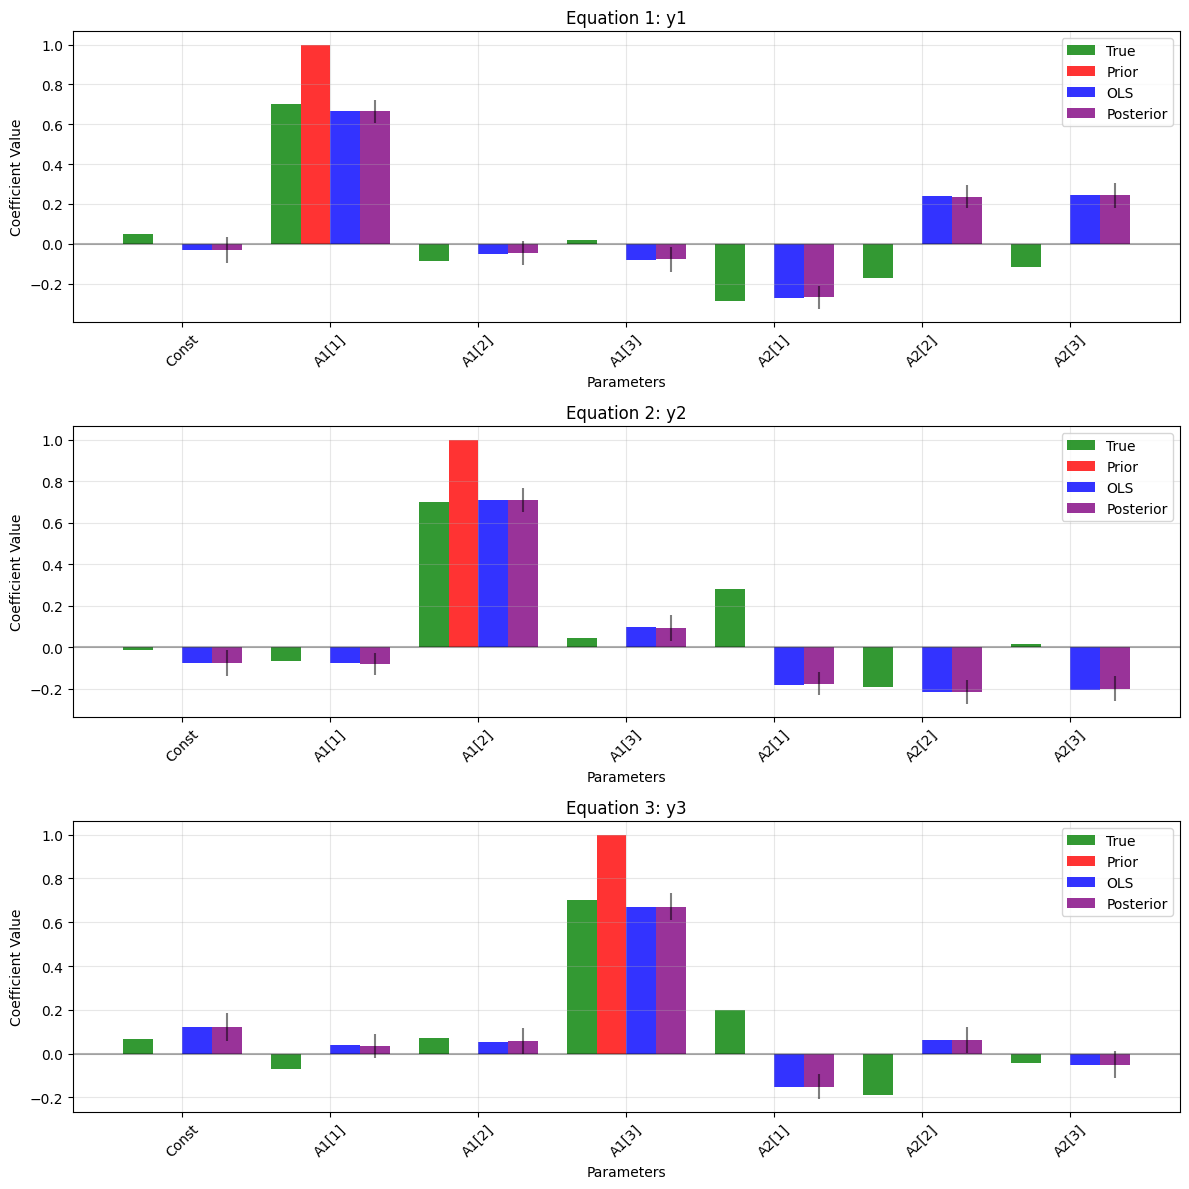

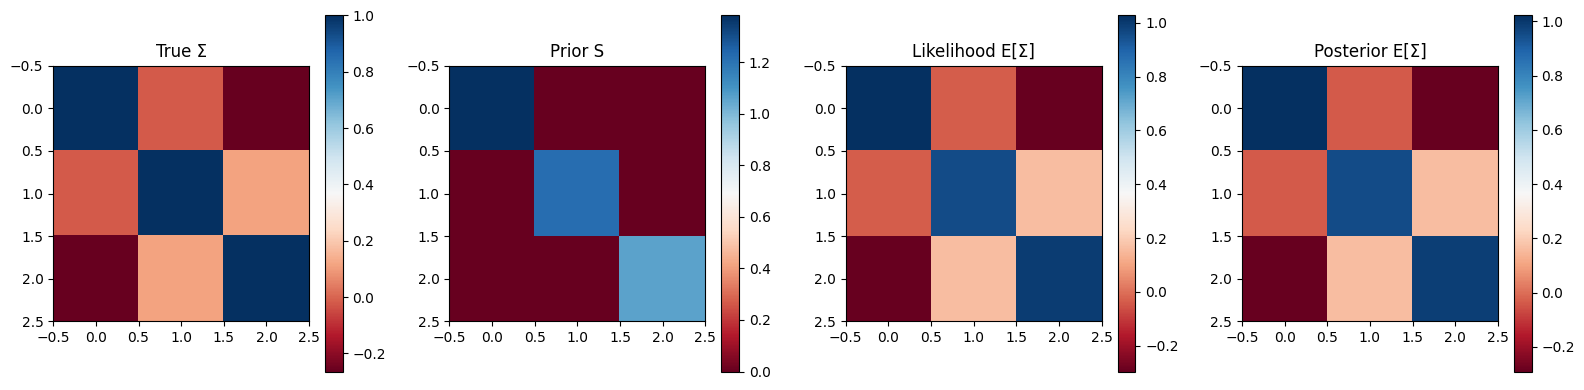


BAYESIAN VAR POSTERIOR ANALYSIS SUMMARY
Data: N=3 variables, T=1000 observations, p=2 lags
Prior: Minnesota with λ₀=1.0, λ₁=0.2
Posterior: Normal-Wishart with ν*=1005

Accuracy Comparison:
OLS MAE:       0.1296
Posterior MAE: 0.1282
Improvement:   1.1%
Prior Influence: 2.4% deviation from OLS
Bayesian VAR estimation completed successfully!
Results show posterior combines prior beliefs with data evidence.


In [12]:
# Posterior Distribution

from scipy.stats import invwishart, chi2

def compute_posterior_parameters(Y_matrix, X_matrix, A_bar, V, S_prior, nu_prior):
    """
    Compute posterior parameters menggunakan persamaan (25)
    
    Returns:
    V_star : posterior covariance
    A_star : posterior mean  
    S_star : posterior scale matrix
    nu_star : posterior degrees of freedom
    """
    T, N = Y_matrix.shape
    
    # V* = (V^-1 + X'X)^-1
    V_inv = linalg.inv(V)
    XtX = X_matrix.T @ X_matrix
    V_star = linalg.inv(V_inv + XtX)
    
    # A* = V* (V^-1 A + X'Y)
    A_star = V_star @ (V_inv @ A_bar + X_matrix.T @ Y_matrix)
    
    # ν* = ν + T  
    nu_star = nu_prior + T
    
    # S* = S + Y'Y + A'V^-1 A - A*'V*^-1 A*
    YtY = Y_matrix.T @ Y_matrix
    term1 = A_bar.T @ V_inv @ A_bar
    term2 = A_star.T @ linalg.inv(V_star) @ A_star
    S_star = S_prior + YtY + term1 - term2
    
    return V_star, A_star, S_star, nu_star

def compute_posterior_moments(A_star, V_star, S_star, nu_star):
    """
    Compute posterior means dan variances
    """
    N = S_star.shape[0]
    
    # Posterior mean
    A_mean = A_star
    Sigma_mean = S_star / (nu_star - N - 1)
    
    # Posterior variance untuk A (diagonal elements saja)
    A_var_diag = np.diag(Sigma_mean)[:, None] @ np.diag(V_star)[None, :]
    
    return A_mean, Sigma_mean, A_var_diag

def compute_credible_intervals(A_star, V_star, S_star, nu_star, alpha=0.05):
    """
    Compute credible intervals untuk posterior parameters
    """
    K, N = A_star.shape
    
    # Expected Sigma
    Sigma_mean = S_star / (nu_star - N - 1)
    
    # Standard errors untuk A
    A_se = np.zeros((K, N))
    for i in range(K):
        for j in range(N):
            A_se[i, j] = np.sqrt(Sigma_mean[j, j] * V_star[i, i])
    
    # t-distribution critical value (approximate)
    t_crit = chi2.ppf(1 - alpha/2, df=nu_star) / nu_star
    t_crit = np.sqrt(t_crit)
    
    # Credible intervals
    A_lower = A_star - t_crit * A_se
    A_upper = A_star + t_crit * A_se
    
    return A_lower, A_upper, A_se

def compare_estimates(A_true_full, A_hat, A_bar, A_star, param_names):
    """
    Compare different estimates
    """
    K, N = A_star.shape
    
    # Create comparison DataFrame
    results = []
    
    for i in range(K):
        for j in range(N):
            results.append({
                'Parameter': f'{param_names[i]}_eq{j+1}',
                'True': A_true_full[i, j],
                'OLS': A_hat[i, j], 
                'Prior': A_bar[i, j],
                'Posterior': A_star[i, j],
                'OLS_Error': A_hat[i, j] - A_true_full[i, j],
                'Post_Error': A_star[i, j] - A_true_full[i, j]
            })
    
    df_compare = pd.DataFrame(results)
    
    return df_compare

def plot_parameter_evolution(A_true_full, A_hat, A_bar, A_star, A_se, param_names):
    """
    Plot parameter evolution: Prior → OLS → Posterior
    """
    K, N = A_star.shape
    
    fig, axes = plt.subplots(N, 1, figsize=(12, 4*N))
    if N == 1:
        axes = [axes]
    
    for eq in range(N):
        x_pos = np.arange(K)
        width = 0.2
        
        # Plot different estimates
        axes[eq].bar(x_pos - 1.5*width, A_true_full[:, eq], width, 
                    label='True', alpha=0.8, color='green')
        axes[eq].bar(x_pos - 0.5*width, A_bar[:, eq], width, 
                    label='Prior', alpha=0.8, color='red')
        axes[eq].bar(x_pos + 0.5*width, A_hat[:, eq], width, 
                    label='OLS', alpha=0.8, color='blue')
        axes[eq].bar(x_pos + 1.5*width, A_star[:, eq], width, 
                    label='Posterior', alpha=0.8, color='purple')
        
        # Add error bars untuk posterior
        axes[eq].errorbar(x_pos + 1.5*width, A_star[:, eq], 
                         yerr=1.96*A_se[:, eq], fmt='none', color='black', alpha=0.5)
        
        axes[eq].set_title(f'Equation {eq+1}: y{eq+1}')
        axes[eq].set_xlabel('Parameters')
        axes[eq].set_ylabel('Coefficient Value')
        axes[eq].set_xticks(x_pos)
        axes[eq].set_xticklabels(param_names, rotation=45)
        axes[eq].legend()
        axes[eq].grid(True, alpha=0.3)
        axes[eq].axhline(y=0, color='black', linestyle='-', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def plot_sigma_comparison(Sigma_true, Sigma_expected, S_prior, Sigma_mean):
    """
    Plot Sigma evolution
    """
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    
    # True Sigma
    im1 = axes[0].imshow(Sigma_true, cmap='RdBu')
    axes[0].set_title('True Σ')
    plt.colorbar(im1, ax=axes[0])
    
    # Prior S
    im2 = axes[1].imshow(S_prior, cmap='RdBu')
    axes[1].set_title('Prior S')
    plt.colorbar(im2, ax=axes[1])
    
    # Likelihood expectation
    im3 = axes[2].imshow(Sigma_expected, cmap='RdBu')
    axes[2].set_title('Likelihood E[Σ]')
    plt.colorbar(im3, ax=axes[2])
    
    # Posterior mean
    im4 = axes[3].imshow(Sigma_mean, cmap='RdBu')
    axes[3].set_title('Posterior E[Σ]')
    plt.colorbar(im4, ax=axes[3])
    
    plt.tight_layout()
    plt.show()

# =============================================================================
# IMPLEMENTASI POSTERIOR COMPUTATION
# =============================================================================

print("Computing Bayesian VAR Posterior Distribution")
print("=" * 55)

# Compute posterior parameters (persamaan 25)
V_star, A_star, S_star, nu_star = compute_posterior_parameters(
    Y_matrix, X_matrix, A_bar, V, S_prior, nu
)

print("Posterior Parameters Computed:")
print(f"V* shape: {V_star.shape}")
print(f"A* shape: {A_star.shape}")  
print(f"S* shape: {S_star.shape}")
print(f"ν*: {nu_star}")

# Compute posterior moments
A_mean, Sigma_mean, A_var_diag = compute_posterior_moments(A_star, V_star, S_star, nu_star)

print(f"\nPosterior Means:")
print(f"E[A|Y]:")
print(A_mean)
print(f"E[Σ|Y]:")
print(Sigma_mean)

# Compute credible intervals
A_lower, A_upper, A_se = compute_credible_intervals(A_star, V_star, S_star, nu_star)

print(f"\nPosterior Standard Errors:")
print(A_se)

# Parameter names untuk plotting
param_names = ['Const'] + [f'A{l}[{i}]' for l in range(1, p+1) for i in range(1, N+1)]

# Comparison table
df_comparison = compare_estimates(A_true_full, A_hat, A_bar, A_star, param_names)

print(f"\nParameter Comparison Summary:")
print("=" * 40)
print(f"Mean Absolute Error (OLS):       {df_comparison['OLS_Error'].abs().mean():.4f}")
print(f"Mean Absolute Error (Posterior): {df_comparison['Post_Error'].abs().mean():.4f}")
print(f"Max Absolute Error (OLS):        {df_comparison['OLS_Error'].abs().max():.4f}")
print(f"Max Absolute Error (Posterior):  {df_comparison['Post_Error'].abs().max():.4f}")

# Detailed comparison
print(f"\nDetailed Parameter Comparison:")
print(df_comparison.round(4))

# Visualizations
print(f"\nGenerating Visualizations...")

# Parameter evolution plot
plot_parameter_evolution(A_true_full, A_hat, A_bar, A_star, A_se, param_names)

# Sigma comparison plot  
plot_sigma_comparison(Sigma_true, Sigma_expected, S_prior, Sigma_mean)

# Summary statistics
print(f"\n" + "=" * 55)
print("BAYESIAN VAR POSTERIOR ANALYSIS SUMMARY")
print("=" * 55)

print(f"Data: N={N} variables, T={T} observations, p={p} lags")
print(f"Prior: Minnesota with λ₀={lambda_0}, λ₁={lambda_1}")
print(f"Posterior: Normal-Wishart with ν*={nu_star}")

# Check if posterior improved over OLS
ols_mae = df_comparison['OLS_Error'].abs().mean()
post_mae = df_comparison['Post_Error'].abs().mean()
improvement = (ols_mae - post_mae) / ols_mae * 100

print(f"\nAccuracy Comparison:")
print(f"OLS MAE:       {ols_mae:.4f}")
print(f"Posterior MAE: {post_mae:.4f}")
print(f"Improvement:   {improvement:.1f}%")

# Prior influence
prior_influence = np.mean(np.abs(A_star - A_hat) / (np.abs(A_hat) + 1e-8))
print(f"Prior Influence: {prior_influence:.1%} deviation from OLS")

print("=" * 55)
print("Bayesian VAR estimation completed successfully!")
print("Results show posterior combines prior beliefs with data evidence.")
print("=" * 55)